# Sentiment Classifier for Rotten Tomatoes Movie Reviews

## III. Modeling

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
!pip install scikeras[tensorflow]

     |████████████████████████████████| 462 kB 7.9 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.1
    Uninstalling importlib-metadata-4.11.1:
      Successfully uninstalled importlib-metadata-4.11.1
  Attempting uninstall: markdown
    Found existing installation: Markdown 3.3.6
    Uninstalling Markdown-3.3.6:
      Successfully uninstalled Markdown-3.3.6


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('dark_background')
plt.style.use(style="seaborn")
%matplotlib inline

# Import custom preprocessing functions
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/final-project/src/modules/')
#sys.path.insert(0, 'modules/')
from data_preprocessing import *

# NLP
from nltk.tokenize import word_tokenize
import nltk

# For splitting the data
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For building the LSTM
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

# For cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# For saving models
import pickle
import joblib

# For model evaluation
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


We can load the cleaned data from the previous section.

In [ ]:
#reviews = pd.read_csv('../data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')
reviews = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final-project/data/rotten_tomatoes/reviews_clean.csv', encoding='utf-8')
reviews_300k = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final-project/data/rotten_tomatoes/reviews_300k.csv', encoding='utf-8')

Let's make sure that the `Text` column values are of type *str* 

In [ ]:
reviews['Text'] = reviews['Text'].astype('str')
reviews_300k['Text'] = reviews_300k['Text'].astype('str')

In [ ]:
reviews.head()

Text  Type
0  fantasy adventure fuse greek mythology contemp...     1
1  uma thurman medusa gorgon coiffure writhing sn...     1
2  topnotch cast dazzling special effect tide tee...     1
3  whether audience get behind lightning thief ha...     1
4  really lacking lightning thief genuine sense w...     0

In [ ]:
reviews_300k.head()

Text  Type
0      real meat potato proposition satisfying tasty     1
1  young old jock nerd geek freak everyone able f...     1
2  strong performance thornton kinnear barely com...     1
3     entertaining romp succeeds level pure escapism     1
4  borgesian critique exotic backdrop scoundrel h...     1

### GloVe Embeddings

[GloVe](https://nlp.stanford.edu/projects/glove/) is an unsupervised learning algorithm for obtaining vectorizing words. Training is performed on aggregated global word-word co-occurrence from a corpus, and the resulting representations showcase linear substructures of the word vector space.

A 300D variation of GloVe pretrained corpus model will be used to represent the words for this project.

The corpus will be created from a custom function *create_corpus*.

In [ ]:
#corpus = create_corpus(reviews)
corpus = create_corpus(reviews_300k)

In [ ]:
num_docs = len(corpus)
print(num_docs)

300000


In [ ]:
corpus[0]

['real', 'meat', 'potato', 'proposition', 'satisfying', 'tasty']

In [ ]:
words_corpus = []
for list in corpus:
  for word in list:
    words_corpus.append(word)
  
words_joined = ' '.join(words_corpus)

In [ ]:
num_words = len(words_corpus)
print(num_words)

3613747


We have around 3.6M+ unique words in our corpus. Let's take a peek at the most common words.

In [ ]:
word_counter(words_joined).most_common(20)

[('film', 55571),
 ('movie', 42070),
 ('one', 25390),
 ('like', 20486),
 ('story', 17990),
 ('make', 16783),
 ('character', 13971),
 ('time', 13214),
 ('much', 12689),
 ('good', 12520),
 ('performance', 12149),
 ('even', 12105),
 ('comedy', 10754),
 ('way', 10315),
 ('feel', 9983),
 ('work', 9766),
 ('best', 9765),
 ('get', 9338),
 ('life', 8578),
 ('would', 8552)]

### Train / Test Split

In [ ]:
X = reviews_300k.iloc[:,:-1]
y = reviews_300k.iloc[:,-1]

In [ ]:
train_size = int(reviews_300k.shape[0] * 0.7)

In [ ]:
train_size

210000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

In [ ]:
train_sentences = X_train['Text']
train_labels = y_train

test_sentences = X_test['Text']
test_labels = y_test

In [ ]:
max_len = 50

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
train_sentences

199634    dark phoenix going one divisive blockbuster su...
174283    beach night alone definitely deserves watch pa...
67812          depps movie close comeback role could wanted
121066    recounting true story honesty depth proper sen...
73223     strong special effect can not overcome story s...
                                ...                        
54941           exactly revelation novel take biopic format
92231     film reveals story protagonist three well comp...
102321    zahn specializes playing overgrown child face ...
106071    uncompromising end leave room hope foster inte...
183206    dunst movie strongest weakest element natural ...
Name: Text, Length: 210000, dtype: object

In [ ]:
train_sequences[0]

[160, 2194, 138, 3, 9216, 661, 270, 53, 281, 76, 715, 8300, 1267, 879, 340, 7]

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_len, truncating="post", padding="post")

In [ ]:
train_padded

array([[  160,  2194,   138, ...,     0,     0,     0],
       [ 3102,   329,   691, ...,     0,     0,     0],
       [ 5988,     2,   386, ...,     0,     0,     0],
       ...,
       [14313, 19019,   458, ...,     0,     0,     0],
       [ 3347,    55,   333, ...,     0,     0,     0],
       [ 8739,     2,  2888, ...,     0,     0,     0]], dtype=int32)

In [ ]:
train_padded[0]

array([ 160, 2194,  138,    3, 9216,  661,  270,   53,  281,   76,  715,
       8300, 1267,  879,  340,    7,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
test_padded

array([[ 257, 4775,   24, ...,    0,    0,    0],
       [ 247,  991,    0, ...,    0,    0,    0],
       [5487,  110,   20, ...,    0,    0,    0],
       ...,
       [  12,  143,   34, ...,    0,    0,    0],
       [6524, 2148, 3037, ...,    0,    0,    0],
       [6029,   39, 1263, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print(X_train['Text'].iloc[0])
print(train_sequences[0])

dark phoenix going one divisive blockbuster summer many problem find success diving deeper intimate relationship character
[160, 2194, 138, 3, 9216, 661, 270, 53, 281, 76, 715, 8300, 1267, 879, 340, 7]


In [ ]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 92731


In [ ]:
word_index

{'film': 1,
 'movie': 2,
 'one': 3,
 'like': 4,
 'story': 5,
 'make': 6,
 'character': 7,
 'time': 8,
 'much': 9,
 'good': 10,
 'performance': 11,
 'even': 12,
 'comedy': 13,
 'way': 14,
 'feel': 15,
 'best': 16,
 'work': 17,
 'get': 18,
 'would': 19,
 'life': 20,
 'never': 21,
 'director': 22,
 'little': 23,
 'enough': 24,
 'full': 25,
 'great': 26,
 'u': 27,
 'action': 28,
 'funny': 29,
 'fun': 30,
 'take': 31,
 'may': 32,
 'year': 33,
 'could': 34,
 'drama': 35,
 'come': 36,
 'well': 37,
 'thing': 38,
 'still': 39,
 'love': 40,
 'first': 41,
 'look': 42,
 'go': 43,
 'new': 44,
 'made': 45,
 'see': 46,
 'really': 47,
 'also': 48,
 'review': 49,
 'something': 50,
 'moment': 51,
 'better': 52,
 'many': 53,
 'audience': 54,
 'end': 55,
 'two': 56,
 'thriller': 57,
 'world': 58,
 'might': 59,
 'cast': 60,
 'spanish': 61,
 'horror': 62,
 'plot': 63,
 'entertaining': 64,
 'every': 65,
 'bad': 66,
 'without': 67,
 'people': 68,
 'though': 69,
 'give': 70,
 'scene': 71,
 'tale': 72,
 'yet': 

In [ ]:
print(X_train['Text'].iloc[0])
print(train_sequences[0])

dark phoenix going one divisive blockbuster summer many problem find success diving deeper intimate relationship character
[160, 2194, 138, 3, 9216, 661, 270, 53, 281, 76, 715, 8300, 1267, 879, 340, 7]


In [ ]:
word_index['blockbuster']

661

In [ ]:
X_train.tail()

Text
54941         exactly revelation novel take biopic format
92231   film reveals story protagonist three well comp...
102321  zahn specializes playing overgrown child face ...
106071  uncompromising end leave room hope foster inte...
183206  dunst movie strongest weakest element natural ...

In [ ]:
print(X_train['Text'].iloc[train_size-1])
print(train_sequences[train_size-1])

dunst movie strongest weakest element natural charm carry u scenery time distinct americanness ring false every scene
[8739, 2, 2888, 4218, 271, 958, 245, 686, 27, 2298, 8, 3012, 92731, 937, 1961, 65, 71]


In [ ]:
word_index["strongest"]

2888

### Create the Embedding Dictionary

In [ ]:
embedding_dict = {}
with open('/content/drive/My Drive/Colab Notebooks/final-project/data/glove.6B/glove.6B.300d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [ ]:
len(embedding_dict['blockbuster'])

300

In [ ]:
len(embedding_dict)

400000

In [ ]:
embedding_dict

{'the': array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-0

In [ ]:
word_index.items()

dict_items([('film', 1), ('movie', 2), ('one', 3), ('like', 4), ('story', 5), ('make', 6), ('character', 7), ('time', 8), ('much', 9), ('good', 10), ('performance', 11), ('even', 12), ('comedy', 13), ('way', 14), ('feel', 15), ('best', 16), ('work', 17), ('get', 18), ('would', 19), ('life', 20), ('never', 21), ('director', 22), ('little', 23), ('enough', 24), ('full', 25), ('great', 26), ('u', 27), ('action', 28), ('funny', 29), ('fun', 30), ('take', 31), ('may', 32), ('year', 33), ('could', 34), ('drama', 35), ('come', 36), ('well', 37), ('thing', 38), ('still', 39), ('love', 40), ('first', 41), ('look', 42), ('go', 43), ('new', 44), ('made', 45), ('see', 46), ('really', 47), ('also', 48), ('review', 49), ('something', 50), ('moment', 51), ('better', 52), ('many', 53), ('audience', 54), ('end', 55), ('two', 56), ('thriller', 57), ('world', 58), ('might', 59), ('cast', 60), ('spanish', 61), ('horror', 62), ('plot', 63), ('entertaining', 64), ('every', 65), ('bad', 66), ('without', 67),

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            # Words that are not found in the embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(92732, 300)

In [ ]:
word_index["blockbuster"]

661

In [ ]:
embedding_dict.get("blockbuster")

array([ 1.4185e-01, -1.1563e-01,  4.4587e-01,  4.2981e-01,  1.3413e-01,
        3.3223e-01, -3.8965e-01,  6.8437e-03, -4.0429e-01,  1.0239e-01,
        6.8241e-01, -2.1756e-01, -4.5551e-01,  2.9158e-01,  3.5088e-03,
       -3.7094e-01, -5.3451e-01, -1.7253e-02,  1.7496e-01,  4.3875e-01,
        1.3112e-01, -1.3521e-01,  3.4100e-01,  3.4355e-01,  5.1708e-02,
        5.2103e-01,  1.2331e-01, -5.6398e-01,  1.3734e-01,  1.3778e-01,
       -5.1258e-01, -6.1360e-02,  1.4984e-01, -2.5250e-01, -8.6059e-01,
       -2.4643e-01, -5.8911e-01,  1.1756e-03, -2.1316e-01,  2.3519e-01,
        4.3684e-01, -1.9132e-01, -3.8131e-01,  6.3526e-01, -8.1783e-02,
       -2.6290e-01,  1.8309e-01, -6.3878e-01,  1.6338e-01,  5.2237e-01,
        1.7850e-01, -9.1054e-01, -5.3003e-01,  3.2074e-01,  2.8474e-01,
        7.9027e-02, -1.1890e-01,  1.9766e-01,  1.9858e-02, -8.0195e-02,
       -2.6211e-01, -1.5413e-01,  1.5403e-01, -4.1213e-01,  6.7287e-01,
       -9.7819e-02, -2.4592e-01, -7.4397e-02,  3.2621e-01,  5.35

Let's check if the embeddings match in the the matrix and ditionary.

In [ ]:
(embedding_matrix[661] == embedding_dict.get("blockbuster")).all()

True

In [ ]:
embedding_dict.get('blockbuster')

array([ 1.4185e-01, -1.1563e-01,  4.4587e-01,  4.2981e-01,  1.3413e-01,
        3.3223e-01, -3.8965e-01,  6.8437e-03, -4.0429e-01,  1.0239e-01,
        6.8241e-01, -2.1756e-01, -4.5551e-01,  2.9158e-01,  3.5088e-03,
       -3.7094e-01, -5.3451e-01, -1.7253e-02,  1.7496e-01,  4.3875e-01,
        1.3112e-01, -1.3521e-01,  3.4100e-01,  3.4355e-01,  5.1708e-02,
        5.2103e-01,  1.2331e-01, -5.6398e-01,  1.3734e-01,  1.3778e-01,
       -5.1258e-01, -6.1360e-02,  1.4984e-01, -2.5250e-01, -8.6059e-01,
       -2.4643e-01, -5.8911e-01,  1.1756e-03, -2.1316e-01,  2.3519e-01,
        4.3684e-01, -1.9132e-01, -3.8131e-01,  6.3526e-01, -8.1783e-02,
       -2.6290e-01,  1.8309e-01, -6.3878e-01,  1.6338e-01,  5.2237e-01,
        1.7850e-01, -9.1054e-01, -5.3003e-01,  3.2074e-01,  2.8474e-01,
        7.9027e-02, -1.1890e-01,  1.9766e-01,  1.9858e-02, -8.0195e-02,
       -2.6211e-01, -1.5413e-01,  1.5403e-01, -4.1213e-01,  6.7287e-01,
       -9.7819e-02, -2.4592e-01, -7.4397e-02,  3.2621e-01,  5.35

In [ ]:
print(train_padded.shape)
print(train_labels.shape)

(210000, 50)
(210000,)


In [ ]:
print(test_padded.shape)
print(test_labels.shape)

(90000, 50)
(90000,)


### Baseline Model with GloVe

The baseline model is a LSTM with 300 units and a dropout of 0.1.The Adam optimizer is set to have a learing rate of 3e-4. The matrix that was built with GloVe embeddings would be fed into it.

In [ ]:
model = Sequential()

model.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model.add(LSTM(300, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def build_model_lstm():
  model = Sequential()

  model.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
      )
  )
  model.add(LSTM(300, dropout=0.1))
  model.add(Dense(1, activation="sigmoid"))

  optimizer = Adam(learning_rate=3e-4)

  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

### Hyperparameter Tuning for Base Model

#### Randomized Search CV

To tune the parameters, the *RandomizedSearchCV* will be used for speed purposesbecause of the large dataset.

In [ ]:
# Custom randomized search function with KerasClassifier
def randomized_search_cv(X, y, batch_size=64, epoch_size=20):
    model = KerasClassifier(build_fn=build_model_lstm, epochs=epoch_size, batch_size=batch_size, verbose=1)
    param_distributions = {
        'epochs': [20, 50],
        'batch_size': [64, 128]
        
    }   
    randomized = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_jobs=1, cv=3, verbose=1) # -1 for n_jobs means using all processor and runs in parallel, 1 turns this off
    randomized_result = randomized.fit(X, y)   
    return randomized_result.cv_results_ # returns all the results of the randomized search run 

In [ ]:
randomized_search_cv(train_padded, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/20
2188/2188 [==============================] - 27s 9ms/step - loss: 0.5155 - accuracy: 0.7429
Epoch 2/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4726 - accuracy: 0.7711
Epoch 3/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4473 - accuracy: 0.7879
Epoch 4/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4268 - accuracy: 0.8005
Epoch 5/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4074 - accuracy: 0.8121
Epoch 6/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3876 - accuracy: 0.8234
Epoch 7/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3667 - accuracy: 0.8357
Epoch 8/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3441 - accuracy: 0.8476
Epoch 9/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3198 - accuracy: 0.8603
Epoch 10/20
2

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
2188/2188 [==============================] - 23s 9ms/step - loss: 0.5133 - accuracy: 0.7439
Epoch 2/20
2188/2188 [==============================] - 21s 9ms/step - loss: 0.4710 - accuracy: 0.7714
Epoch 3/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4444 - accuracy: 0.7895
Epoch 4/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4230 - accuracy: 0.8030
Epoch 5/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4033 - accuracy: 0.8142
Epoch 6/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3834 - accuracy: 0.8250
Epoch 7/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3619 - accuracy: 0.8370
Epoch 8/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3387 - accuracy: 0.8504
Epoch 9/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3158 - accuracy: 0.8623
Epoch 10/20
2188/2188 [==============================] - 20s 9ms/step - l

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
2188/2188 [==============================] - 22s 9ms/step - loss: 0.5160 - accuracy: 0.7427
Epoch 2/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4731 - accuracy: 0.7705
Epoch 3/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4451 - accuracy: 0.7903
Epoch 4/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4239 - accuracy: 0.8002
Epoch 5/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4056 - accuracy: 0.8120
Epoch 6/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3848 - accuracy: 0.8244
Epoch 7/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3643 - accuracy: 0.8347
Epoch 8/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3416 - accuracy: 0.8481
Epoch 9/20
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3183 - accuracy: 0.8595
Epoch 10/20
2188/2188 [==============================] - 20s 9ms/step - l

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
2188/2188 [==============================] - 23s 9ms/step - loss: 0.5145 - accuracy: 0.7436
Epoch 2/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4726 - accuracy: 0.7715
Epoch 3/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4460 - accuracy: 0.7889
Epoch 4/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4256 - accuracy: 0.8005
Epoch 5/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4046 - accuracy: 0.8136
Epoch 6/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3875 - accuracy: 0.8235
Epoch 7/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3659 - accuracy: 0.8357
Epoch 8/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3425 - accuracy: 0.8478
Epoch 9/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3184 - accuracy: 0.8608
Epoch 10/50
2188/2188 [==============================] - 20s 9ms/step - l

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
2188/2188 [==============================] - 22s 9ms/step - loss: 0.5135 - accuracy: 0.7445
Epoch 2/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4695 - accuracy: 0.7742
Epoch 3/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4417 - accuracy: 0.7904
Epoch 4/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4223 - accuracy: 0.8038
Epoch 5/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4033 - accuracy: 0.8156
Epoch 6/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3834 - accuracy: 0.8259
Epoch 7/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3615 - accuracy: 0.8375
Epoch 8/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3396 - accuracy: 0.8500
Epoch 9/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3151 - accuracy: 0.8630
Epoch 10/50
2188/2188 [==============================] - 20s 9ms/step - l

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
2188/2188 [==============================] - 22s 9ms/step - loss: 0.5163 - accuracy: 0.7428
Epoch 2/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4733 - accuracy: 0.7711
Epoch 3/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4458 - accuracy: 0.7877
Epoch 4/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4256 - accuracy: 0.7987
Epoch 5/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4068 - accuracy: 0.8112
Epoch 6/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3869 - accuracy: 0.8219
Epoch 7/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3675 - accuracy: 0.8321
Epoch 8/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3446 - accuracy: 0.8458
Epoch 9/50
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3216 - accuracy: 0.8574
Epoch 10/50
2188/2188 [==============================] - 20s 9ms/step - l

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
1094/1094 [==============================] - 14s 11ms/step - loss: 0.5200 - accuracy: 0.7395
Epoch 2/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4774 - accuracy: 0.7671
Epoch 3/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4526 - accuracy: 0.7840
Epoch 4/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4337 - accuracy: 0.7953
Epoch 5/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4161 - accuracy: 0.8056
Epoch 6/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4017 - accuracy: 0.8146
Epoch 7/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3863 - accuracy: 0.8243
Epoch 8/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3698 - accuracy: 0.8325
Epoch 9/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3527 - accuracy: 0.8431
Epoch 10/20
1094/1094 [==============================] - 12s 11m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
1094/1094 [==============================] - 14s 11ms/step - loss: 0.5165 - accuracy: 0.7416
Epoch 2/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4754 - accuracy: 0.7693
Epoch 3/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4500 - accuracy: 0.7861
Epoch 4/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4306 - accuracy: 0.7970
Epoch 5/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4154 - accuracy: 0.8063
Epoch 6/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4005 - accuracy: 0.8155
Epoch 7/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3844 - accuracy: 0.8250
Epoch 8/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3688 - accuracy: 0.8334
Epoch 9/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3513 - accuracy: 0.8434
Epoch 10/20
1094/1094 [==============================] - 12s 11m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
1094/1094 [==============================] - 14s 11ms/step - loss: 0.5188 - accuracy: 0.7402
Epoch 2/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4763 - accuracy: 0.7677
Epoch 3/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4529 - accuracy: 0.7816
Epoch 4/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4347 - accuracy: 0.7944
Epoch 5/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4185 - accuracy: 0.8043
Epoch 6/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4025 - accuracy: 0.8147
Epoch 7/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3862 - accuracy: 0.8219
Epoch 8/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3711 - accuracy: 0.8320
Epoch 9/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3532 - accuracy: 0.8409
Epoch 10/20
1094/1094 [==============================] - 12s 11m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
1094/1094 [==============================] - 15s 11ms/step - loss: 0.5183 - accuracy: 0.7397
Epoch 2/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4768 - accuracy: 0.7681
Epoch 3/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4521 - accuracy: 0.7843
Epoch 4/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4333 - accuracy: 0.7959
Epoch 5/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4188 - accuracy: 0.8047
Epoch 6/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4022 - accuracy: 0.8140
Epoch 7/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3864 - accuracy: 0.8234
Epoch 8/50
1094/1094 [==============================] - 13s 11ms/step - loss: 0.3701 - accuracy: 0.8323
Epoch 9/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3525 - accuracy: 0.8426
Epoch 10/50
1094/1094 [==============================] - 12s 11m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
1094/1094 [==============================] - 16s 11ms/step - loss: 0.5150 - accuracy: 0.7415
Epoch 2/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4743 - accuracy: 0.7696
Epoch 3/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4504 - accuracy: 0.7855
Epoch 4/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4318 - accuracy: 0.7977
Epoch 5/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4169 - accuracy: 0.8064
Epoch 6/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.4006 - accuracy: 0.8161
Epoch 7/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3845 - accuracy: 0.8248
Epoch 8/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3695 - accuracy: 0.8334
Epoch 9/50
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3518 - accuracy: 0.8435
Epoch 10/50
1094/1094 [==============================] - 12s 11m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/50
1094/1094 [==============================] - 15s 12ms/step - loss: 0.5188 - accuracy: 0.7394
Epoch 2/50
1094/1094 [==============================] - 13s 12ms/step - loss: 0.4766 - accuracy: 0.7678
Epoch 3/50
1094/1094 [==============================] - 13s 11ms/step - loss: 0.4523 - accuracy: 0.7829
Epoch 4/50
1094/1094 [==============================] - 13s 12ms/step - loss: 0.4321 - accuracy: 0.7962
Epoch 5/50
1094/1094 [==============================] - 13s 12ms/step - loss: 0.4163 - accuracy: 0.8048
Epoch 6/50
1094/1094 [==============================] - 13s 12ms/step - loss: 0.4014 - accuracy: 0.8134
Epoch 7/50
1094/1094 [==============================] - 13s 11ms/step - loss: 0.3852 - accuracy: 0.8228
Epoch 8/50
1094/1094 [==============================] - 13s 12ms/step - loss: 0.3690 - accuracy: 0.8330
Epoch 9/50
1094/1094 [==============================] - 13s 11ms/step - loss: 0.3513 - accuracy: 0.8417
Epoch 10/50
1094/1094 [==============================] - 13s 12m

/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/20
3282/3282 [==============================] - 33s 9ms/step - loss: 0.5033 - accuracy: 0.7509
Epoch 2/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.4565 - accuracy: 0.7817
Epoch 3/20
3282/3282 [==============================] - 31s 9ms/step - loss: 0.4311 - accuracy: 0.7970
Epoch 4/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.4096 - accuracy: 0.8091
Epoch 5/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.3904 - accuracy: 0.8209
Epoch 6/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.3699 - accuracy: 0.8321
Epoch 7/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.3493 - accuracy: 0.8436
Epoch 8/20
3282/3282 [==============================] - 30s 9ms/step - loss: 0.3262 - accuracy: 0.8560
Epoch 9/20
3282/3282 [==============================] - 31s 9ms/step - loss: 0.3030 - accuracy: 0.8678
Epoch 10/20
3282/3282 [==============================] - 31s 9ms/step - l

{'mean_fit_time': array([ 422.90613071, 1023.27942451,  249.57524514,  629.28715189]),
 'mean_score_time': array([4.13229569, 4.04623636, 2.56557576, 2.57302475]),
 'mean_test_score': array([0.78381905, 0.77774762, 0.78280476, 0.77579524]),
 'param_batch_size': masked_array(data=[64, 64, 128, 128],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[20, 50, 20, 50],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 64, 'epochs': 20},
  {'batch_size': 64, 'epochs': 50},
  {'batch_size': 128, 'epochs': 20},
  {'batch_size': 128, 'epochs': 50}],
 'rank_test_score': array([1, 3, 2, 4], dtype=int32),
 'split0_test_score': array([0.78432857, 0.7798    , 0.78377143, 0.78088571]),
 'split1_test_score': array([0.78078571, 0.7759    , 0.77767143, 0.77572857]),
 'split2_test_score': array([0.78634286, 0.77754286, 0.78697143, 0.77077143]

In [ ]:
# Custom grid search function with KerasClassifier
'''def grid_search_cv(X, y, batch_size=64, epoch_size=20):
    model = KerasClassifier(build_fn=build_model_lstm, epochs=epoch_size, batch_size=batch_size, verbose=1)
    param_grid = {
        'epochs': [20, 50],
        'batch_size': [64, 128, 256]
    }   
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1) # -1 for n_jobs means using all processor and runs in parallel, 1 turns this off
    grid_result = grid.fit(X, y)   
    return grid_result.cv_results_ # returns all the results of the grid search run 
'''

In [ ]:
# grid_search_cv(train_padded, train_labels)

In [ ]:
# epochs = [20, 50]
# batch_size = [64, 128]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# param_distributions = dict(batch_size=batch_size, epochs=epochs)

In [ ]:
# gs = GridSearchCV(model, param_grid, n_jobs=1, cv=3, scoring='accuracy')
# rs = RandomizedSearchCV(model, param_distributions, n_jobs=1, cv=3, scoring='accuracy', verbose=1)

In [ ]:
def build_model_lstm_2():
  model_2 = Sequential()

  model_2.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
      )
  )
  model_2.add(LSTM(300, dropout=0.1))
  model_2.add(Dense(1, activation="sigmoid"))

  optimizer = Adam(learning_rate=3e-4)

  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model_2

In [ ]:
# Custom randomized search function with KerasClassifier
def randomized_search_cv_2(X, y, batch_size=64, epoch_size=20):
    model = KerasClassifier(build_fn=build_model_lstm, epochs=epoch_size, batch_size=batch_size, verbose=1)
    param_distributions = {
        'epochs': [20, 50],
        'batch_size': [64, 128],
        'optimizer': ['Adam', 'SGD', 'Nadam', 'Adadelta', 'RMSprop']
        
    }   
    randomized = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_jobs=1, cv=3, verbose=1) # -1 for n_jobs means using all processor and runs in parallel, 1 turns this off
    randomized_result = randomized.fit(X, y)   
    return randomized_result.cv_results_ # returns all the results of the randomized search run 

### Model Training

#### 1st Iteration

In [ ]:
model_lstm = Sequential()

model_lstm.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm.add(LSTM(300, dropout=0.1))
model_lstm.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model_lstm.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
2625/2625 [==============================] - 28s 10ms/step - loss: 0.5106 - accuracy: 0.7463 - val_loss: 0.4790 - val_accuracy: 0.7669
Epoch 2/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.4645 - accuracy: 0.7757 - val_loss: 0.4551 - val_accuracy: 0.7839
Epoch 3/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.4377 - accuracy: 0.7930 - val_loss: 0.4396 - val_accuracy: 0.7940
Epoch 4/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.4169 - accuracy: 0.8053 - val_loss: 0.4447 - val_accuracy: 0.7857
Epoch 5/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.3968 - accuracy: 0.8164 - val_loss: 0.4323 - val_accuracy: 0.7992
Epoch 6/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.3775 - accuracy: 0.8272 - val_loss: 0.4261 - val_accuracy: 0.8031
Epoch 7/20
2625/2625 [==============================] - 25s 10ms/step - loss: 0.3571 - accuracy: 0.8389 - val_loss: 0.4383 -

In [ ]:
model_lstm_1 = Sequential()

model_lstm_1.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_1.add(LSTM(300, dropout=0.1))
model_lstm_1.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_1 = model_lstm_1.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1
)

Epoch 1/20
2625/2625 [==============================] - 28s 9ms/step - loss: 0.5102 - accuracy: 0.7467 - val_loss: 0.4718 - val_accuracy: 0.7719
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4654 - accuracy: 0.7768 - val_loss: 0.4562 - val_accuracy: 0.7877
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4386 - accuracy: 0.7916 - val_loss: 0.4383 - val_accuracy: 0.7953
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4164 - accuracy: 0.8058 - val_loss: 0.4352 - val_accuracy: 0.7999
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3981 - accuracy: 0.8167 - val_loss: 0.4324 - val_accuracy: 0.7991
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3790 - accuracy: 0.8267 - val_loss: 0.4275 - val_accuracy: 0.7968
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3571 - accuracy: 0.8395 - val_loss: 0.4309 - val_ac

#### 2nd Iteration

In [ ]:
model_lstm_2 = Sequential()

model_lstm_2.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_2.add(LSTM(300, dropout=0.1))
model_lstm_2.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_2 = model_lstm_2.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 28s 10ms/step - loss: 0.5096 - accuracy: 0.7461 - val_loss: 0.4757 - val_accuracy: 0.7704
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4648 - accuracy: 0.7760 - val_loss: 0.4583 - val_accuracy: 0.7834
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4376 - accuracy: 0.7926 - val_loss: 0.4384 - val_accuracy: 0.7940
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4172 - accuracy: 0.8061 - val_loss: 0.4433 - val_accuracy: 0.7968
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3965 - accuracy: 0.8173 - val_loss: 0.4411 - val_accuracy: 0.7876
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3755 - accuracy: 0.8297 - val_loss: 0.4280 - val_accuracy: 0.8019
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3555 - accuracy: 0.8393 - val_loss: 0.4347 - val_a

#### 3rd Iteration

Dropout = 0.2 on LSTM

In [ ]:
model_lstm_3 = Sequential()

model_lstm_3.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_3.add(LSTM(300, dropout=0.2))
model_lstm_3.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_3.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_3 = model_lstm_3.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 24s 9ms/step - loss: 0.5166 - accuracy: 0.7419 - val_loss: 0.4927 - val_accuracy: 0.7664
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4720 - accuracy: 0.7711 - val_loss: 0.4598 - val_accuracy: 0.7785
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4474 - accuracy: 0.7863 - val_loss: 0.4382 - val_accuracy: 0.7936
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4278 - accuracy: 0.7985 - val_loss: 0.4340 - val_accuracy: 0.7976
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4113 - accuracy: 0.8081 - val_loss: 0.4285 - val_accuracy: 0.8022
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3948 - accuracy: 0.8184 - val_loss: 0.4312 - val_accuracy: 0.8020
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3771 - accuracy: 0.8278 - val_loss: 0.4293 - val_ac

#### 4th Iteration

Dropout = 0.3 on LSTM

In [ ]:
model_lstm_4 = Sequential()

model_lstm_4.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_4.add(LSTM(300, dropout=0.3))
model_lstm_4.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_4.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_4 = model_lstm_4.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 25s 9ms/step - loss: 0.5218 - accuracy: 0.7385 - val_loss: 0.4769 - val_accuracy: 0.7672
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4799 - accuracy: 0.7655 - val_loss: 0.4557 - val_accuracy: 0.7830
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4572 - accuracy: 0.7808 - val_loss: 0.4390 - val_accuracy: 0.7924
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4404 - accuracy: 0.7896 - val_loss: 0.4361 - val_accuracy: 0.7923
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4251 - accuracy: 0.8001 - val_loss: 0.4298 - val_accuracy: 0.7986
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4107 - accuracy: 0.8074 - val_loss: 0.4225 - val_accuracy: 0.8042
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3968 - accuracy: 0.8162 - val_loss: 0.4235 - val_ac

#### 5th Iteration (Best)

Dropout = 0.6 on LSTM

Adding a dropout of 0.6 would have train and test loss converge better.

In [ ]:
model_lstm_5 = Sequential()

model_lstm_5.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_5.add(LSTM(300, dropout=0.6))
model_lstm_5.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_5.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_5 = model_lstm_5.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 24s 9ms/step - loss: 0.5484 - accuracy: 0.7164 - val_loss: 0.5114 - val_accuracy: 0.7477
Epoch 2/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.5152 - accuracy: 0.7404 - val_loss: 0.4826 - val_accuracy: 0.7687
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4968 - accuracy: 0.7534 - val_loss: 0.4654 - val_accuracy: 0.7749
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4858 - accuracy: 0.7612 - val_loss: 0.4510 - val_accuracy: 0.7871
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4751 - accuracy: 0.7671 - val_loss: 0.4502 - val_accuracy: 0.7888
Epoch 6/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4650 - accuracy: 0.7723 - val_loss: 0.4421 - val_accuracy: 0.7950
Epoch 7/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4576 - accuracy: 0.7773 - val_loss: 0.4294 - val_ac

In [ ]:
model_lstm_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           27819600  
                                                                 
 lstm_3 (LSTM)               (None, 300)               721200    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 28,541,101
Trainable params: 721,501
Non-trainable params: 27,819,600
_________________________________________________________________


In [ ]:
model_lstm_5 = Sequential()

model_lstm_5.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_5.add(LSTM(300, dropout=0.6))
model_lstm_5.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_5.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_5 = model_lstm_5.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 28s 9ms/step - loss: 0.5490 - accuracy: 0.7160 - val_loss: 0.4964 - val_accuracy: 0.7584
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.5150 - accuracy: 0.7413 - val_loss: 0.4698 - val_accuracy: 0.7728
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4970 - accuracy: 0.7532 - val_loss: 0.4673 - val_accuracy: 0.7778
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4847 - accuracy: 0.7607 - val_loss: 0.4493 - val_accuracy: 0.7848
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4740 - accuracy: 0.7677 - val_loss: 0.4408 - val_accuracy: 0.7902
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4649 - accuracy: 0.7729 - val_loss: 0.4491 - val_accuracy: 0.7902
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4567 - accuracy: 0.7790 - val_loss: 0.4344 - val_ac

#### 6th Iteration

Dropout = 0.4 on LSTM

In [ ]:
model_lstm_6 = Sequential()

model_lstm_6.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_6.add(LSTM(300, dropout=0.4))
model_lstm_6.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_6.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_6 = model_lstm_6.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 25s 9ms/step - loss: 0.5304 - accuracy: 0.7311 - val_loss: 0.4920 - val_accuracy: 0.7625
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4919 - accuracy: 0.7577 - val_loss: 0.4641 - val_accuracy: 0.7757
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4695 - accuracy: 0.7718 - val_loss: 0.4520 - val_accuracy: 0.7890
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4531 - accuracy: 0.7815 - val_loss: 0.4399 - val_accuracy: 0.7884
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4387 - accuracy: 0.7908 - val_loss: 0.4320 - val_accuracy: 0.7987
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4273 - accuracy: 0.7972 - val_loss: 0.4258 - val_accuracy: 0.8028
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4151 - accuracy: 0.8050 - val_loss: 0.4278 - val_ac

#### 7th Iteration

Dropout = 0.5 on LSTM

In [ ]:
model_lstm_7 = Sequential()

model_lstm_7.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_7.add(LSTM(300, dropout=0.5))
model_lstm_7.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_7.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_7 = model_lstm_7.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 24s 9ms/step - loss: 0.5379 - accuracy: 0.7257 - val_loss: 0.4926 - val_accuracy: 0.7621
Epoch 2/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.5023 - accuracy: 0.7507 - val_loss: 0.4758 - val_accuracy: 0.7771
Epoch 3/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4810 - accuracy: 0.7639 - val_loss: 0.4555 - val_accuracy: 0.7855
Epoch 4/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4691 - accuracy: 0.7714 - val_loss: 0.4543 - val_accuracy: 0.7744
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4566 - accuracy: 0.7794 - val_loss: 0.4426 - val_accuracy: 0.7938
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4460 - accuracy: 0.7859 - val_loss: 0.4344 - val_accuracy: 0.7980
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4363 - accuracy: 0.7918 - val_loss: 0.4237 - val_ac

#### 8th Iteration

Recurrent Dropout = 0.1

In [ ]:
model_lstm_8 = Sequential()

model_lstm_8.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_8.add(LSTM(300, recurrent_dropout=0.1))
model_lstm_8.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_8.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_8 = model_lstm_8.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 173s 65ms/step - loss: 0.5054 - accuracy: 0.7496 - val_loss: 0.4717 - val_accuracy: 0.7726
Epoch 2/20
2625/2625 [==============================] - 171s 65ms/step - loss: 0.4582 - accuracy: 0.7801 - val_loss: 0.4504 - val_accuracy: 0.7828
Epoch 3/20
2625/2625 [==============================] - 170s 65ms/step - loss: 0.4309 - accuracy: 0.7970 - val_loss: 0.4389 - val_accuracy: 0.7895
Epoch 4/20
2625/2625 [==============================] - 170s 65ms/step - loss: 0.4087 - accuracy: 0.8101 - val_loss: 0.4264 - val_accuracy: 0.8001
Epoch 5/20
2625/2625 [==============================] - 170s 65ms/step - loss: 0.3885 - accuracy: 0.8213 - val_loss: 0.4250 - val_accuracy: 0.8009
Epoch 6/20
2625/2625 [==============================] - 171s 65ms/step - loss: 0.3645 - accuracy: 0.8357 - val_loss: 0.4376 - val_accuracy: 0.8004
Epoch 7/20
2625/2625 [==============================] - 170s 65ms/step - loss: 0.3396 - accuracy: 0.8483 - val_loss: 0

#### 9th Iteration

Dropout = 0.1

Adam optimizer learning rate = 0.0001

In [ ]:
model_lstm_9 = Sequential()

model_lstm_9.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_9.add(LSTM(300, dropout=0.1))
model_lstm_9.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0001)

model_lstm_9.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_9 = model_lstm_9.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 25s 8ms/step - loss: 0.5170 - accuracy: 0.7393 - val_loss: 0.4940 - val_accuracy: 0.7540
Epoch 2/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4801 - accuracy: 0.7651 - val_loss: 0.4654 - val_accuracy: 0.7781
Epoch 3/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4583 - accuracy: 0.7780 - val_loss: 0.4609 - val_accuracy: 0.7783
Epoch 4/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4438 - accuracy: 0.7882 - val_loss: 0.4553 - val_accuracy: 0.7821
Epoch 5/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4317 - accuracy: 0.7954 - val_loss: 0.4406 - val_accuracy: 0.7919
Epoch 6/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4220 - accuracy: 0.8025 - val_loss: 0.4384 - val_accuracy: 0.7936
Epoch 7/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4121 - accuracy: 0.8070 - val_loss: 0.4403 - val_ac

#### 10th Iteration

Dropout = 0.6

Adam optimizer learning rate = 0.0001

In [ ]:
model_lstm_10 = Sequential()

model_lstm_10.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_10.add(LSTM(300, dropout=0.6))
model_lstm_10.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0001)

model_lstm_10.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_10 = model_lstm_10.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 23s 8ms/step - loss: 0.5558 - accuracy: 0.7102 - val_loss: 0.5133 - val_accuracy: 0.7392
Epoch 2/20
2625/2625 [==============================] - 21s 8ms/step - loss: 0.5315 - accuracy: 0.7282 - val_loss: 0.4943 - val_accuracy: 0.7586
Epoch 3/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.5135 - accuracy: 0.7412 - val_loss: 0.4789 - val_accuracy: 0.7702
Epoch 4/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.5039 - accuracy: 0.7475 - val_loss: 0.4770 - val_accuracy: 0.7655
Epoch 5/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4953 - accuracy: 0.7536 - val_loss: 0.4593 - val_accuracy: 0.7801
Epoch 6/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4891 - accuracy: 0.7579 - val_loss: 0.4636 - val_accuracy: 0.7735
Epoch 7/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4836 - accuracy: 0.7613 - val_loss: 0.4590 - val_ac

#### 11th Iteration

Added new LSTM layer

In [ ]:
model_lstm_11 = Sequential()

model_lstm_11.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_11.add(LSTM(300, dropout=0.1, return_sequences=True))
model_lstm_11.add(LSTM(300, dropout=0.1))
model_lstm_11.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_11.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_11 = model_lstm_11.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 44s 16ms/step - loss: 0.5082 - accuracy: 0.7475 - val_loss: 0.4856 - val_accuracy: 0.7687
Epoch 2/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.4640 - accuracy: 0.7755 - val_loss: 0.4531 - val_accuracy: 0.7844
Epoch 3/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.4377 - accuracy: 0.7915 - val_loss: 0.4429 - val_accuracy: 0.7890
Epoch 4/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4154 - accuracy: 0.8051 - val_loss: 0.4287 - val_accuracy: 0.7980
Epoch 5/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.3950 - accuracy: 0.8167 - val_loss: 0.4337 - val_accuracy: 0.7956
Epoch 6/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.3746 - accuracy: 0.8277 - val_loss: 0.4526 - val_accuracy: 0.7836
Epoch 7/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.3529 - accuracy: 0.8416 - val_loss: 0.4288 -

#### 12th Iteration

Added new LSTM layer

Dropout = 0.4

In [ ]:
model_lstm_12 = Sequential()

model_lstm_12.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_12.add(LSTM(300, dropout=0.4, return_sequences=True))
model_lstm_12.add(LSTM(300, dropout=0.4))
model_lstm_12.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_12.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_12 = model_lstm_12.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 44s 16ms/step - loss: 0.5290 - accuracy: 0.7312 - val_loss: 0.4889 - val_accuracy: 0.7579
Epoch 2/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.4884 - accuracy: 0.7582 - val_loss: 0.4635 - val_accuracy: 0.7797
Epoch 3/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.4683 - accuracy: 0.7731 - val_loss: 0.4467 - val_accuracy: 0.7886
Epoch 4/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4520 - accuracy: 0.7832 - val_loss: 0.4359 - val_accuracy: 0.7922
Epoch 5/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4378 - accuracy: 0.7916 - val_loss: 0.4276 - val_accuracy: 0.7992
Epoch 6/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4256 - accuracy: 0.7990 - val_loss: 0.4305 - val_accuracy: 0.7977
Epoch 7/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.4144 - accuracy: 0.8061 - val_loss: 0.4276 -

#### 13th Iteration

Added new LSTM layer

Dropout = 0.6

In [ ]:
model_lstm_13 = Sequential()

model_lstm_13.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_13.add(LSTM(300, dropout=0.6, return_sequences=True))
model_lstm_13.add(LSTM(300, dropout=0.6))
model_lstm_13.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_13.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_13 = model_lstm_13.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 44s 16ms/step - loss: 0.5480 - accuracy: 0.7174 - val_loss: 0.4986 - val_accuracy: 0.7530
Epoch 2/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.5152 - accuracy: 0.7410 - val_loss: 0.4844 - val_accuracy: 0.7599
Epoch 3/20
2625/2625 [==============================] - 42s 16ms/step - loss: 0.4977 - accuracy: 0.7524 - val_loss: 0.4569 - val_accuracy: 0.7818
Epoch 4/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4851 - accuracy: 0.7615 - val_loss: 0.4476 - val_accuracy: 0.7863
Epoch 5/20
2625/2625 [==============================] - 43s 16ms/step - loss: 0.4736 - accuracy: 0.7663 - val_loss: 0.4436 - val_accuracy: 0.7902
Epoch 6/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.4645 - accuracy: 0.7727 - val_loss: 0.4365 - val_accuracy: 0.7911
Epoch 7/20
2625/2625 [==============================] - 44s 17ms/step - loss: 0.4564 - accuracy: 0.7787 - val_loss: 0.4328 -

#### 14th Iteration

Dropout = 0.6

Learning rate = 0.0005

In [ ]:
model_lstm_14 = Sequential()

model_lstm_14.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_14.add(LSTM(300, dropout=0.6))
model_lstm_14.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0005)

model_lstm_14.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_14 = model_lstm_14.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 23s 8ms/step - loss: 0.5475 - accuracy: 0.7193 - val_loss: 0.4844 - val_accuracy: 0.7653
Epoch 2/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.5092 - accuracy: 0.7448 - val_loss: 0.4686 - val_accuracy: 0.7745
Epoch 3/20
2625/2625 [==============================] - 21s 8ms/step - loss: 0.4890 - accuracy: 0.7571 - val_loss: 0.4561 - val_accuracy: 0.7862
Epoch 4/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4725 - accuracy: 0.7688 - val_loss: 0.4444 - val_accuracy: 0.7926
Epoch 5/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4614 - accuracy: 0.7762 - val_loss: 0.4321 - val_accuracy: 0.7930
Epoch 6/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4512 - accuracy: 0.7816 - val_loss: 0.4265 - val_accuracy: 0.7985
Epoch 7/20
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4425 - accuracy: 0.7865 - val_loss: 0.4210 - val_ac

#### 15th Iteration

Repeat model 10 with 50 epochs

Dropout = 0.6

Adam optimizer learning rate = 0.0001

In [ ]:
model_lstm_15 = Sequential()

model_lstm_15.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_15.add(LSTM(300, dropout=0.6))
model_lstm_15.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0001)

model_lstm_15.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_15 = model_lstm_15.fit(
    train_padded,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/50
2625/2625 [==============================] - 24s 8ms/step - loss: 0.5551 - accuracy: 0.7128 - val_loss: 0.5058 - val_accuracy: 0.7469
Epoch 2/50
2625/2625 [==============================] - 21s 8ms/step - loss: 0.5298 - accuracy: 0.7287 - val_loss: 0.4909 - val_accuracy: 0.7584
Epoch 3/50
2625/2625 [==============================] - 21s 8ms/step - loss: 0.5113 - accuracy: 0.7430 - val_loss: 0.4725 - val_accuracy: 0.7729
Epoch 4/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.5010 - accuracy: 0.7496 - val_loss: 0.4790 - val_accuracy: 0.7630
Epoch 5/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4954 - accuracy: 0.7540 - val_loss: 0.4636 - val_accuracy: 0.7785
Epoch 6/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4883 - accuracy: 0.7573 - val_loss: 0.4615 - val_accuracy: 0.7810
Epoch 7/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4827 - accuracy: 0.7618 - val_loss: 0.4544 - val_ac

#### 16th Iteration

Repeat model 15 with reduced dropout

Dropout = 0.2

Adam optimizer learning rate = 0.0001

In [ ]:
model_lstm_16 = Sequential()

model_lstm_16.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_16.add(LSTM(300, dropout=0.2))
model_lstm_16.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0001)

model_lstm_16.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_16 = model_lstm_16.fit(
    train_padded,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/50
2625/2625 [==============================] - 23s 8ms/step - loss: 0.5227 - accuracy: 0.7361 - val_loss: 0.4892 - val_accuracy: 0.7592
Epoch 2/50
2625/2625 [==============================] - 21s 8ms/step - loss: 0.4894 - accuracy: 0.7592 - val_loss: 0.4656 - val_accuracy: 0.7751
Epoch 3/50
2625/2625 [==============================] - 21s 8ms/step - loss: 0.4672 - accuracy: 0.7730 - val_loss: 0.4617 - val_accuracy: 0.7805
Epoch 4/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4537 - accuracy: 0.7811 - val_loss: 0.4498 - val_accuracy: 0.7868
Epoch 5/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4418 - accuracy: 0.7896 - val_loss: 0.4430 - val_accuracy: 0.7892
Epoch 6/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4345 - accuracy: 0.7937 - val_loss: 0.4537 - val_accuracy: 0.7818
Epoch 7/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4251 - accuracy: 0.7993 - val_loss: 0.4376 - val_ac

#### 17th Iteration

Repeat model 15 with reduced dropout

Dropout = 0.4

Adam optimizer learning rate = 0.0001

In [ ]:
model_lstm_17 = Sequential()

model_lstm_17.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_17.add(LSTM(300, dropout=0.4))
model_lstm_17.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.0001)

model_lstm_17.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_17 = model_lstm_17.fit(
    train_padded,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/50
2625/2625 [==============================] - 23s 8ms/step - loss: 0.5374 - accuracy: 0.7256 - val_loss: 0.5015 - val_accuracy: 0.7481
Epoch 2/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.5056 - accuracy: 0.7461 - val_loss: 0.4851 - val_accuracy: 0.7585
Epoch 3/50
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4860 - accuracy: 0.7602 - val_loss: 0.4608 - val_accuracy: 0.7797
Epoch 4/50
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4738 - accuracy: 0.7688 - val_loss: 0.4600 - val_accuracy: 0.7826
Epoch 5/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4661 - accuracy: 0.7732 - val_loss: 0.4571 - val_accuracy: 0.7821
Epoch 6/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4584 - accuracy: 0.7791 - val_loss: 0.4454 - val_accuracy: 0.7886
Epoch 7/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4507 - accuracy: 0.7835 - val_loss: 0.4551 - val_ac

#### 18th Iteration

Repeat model 15 with reduced dropout

Dropout = 0.4

Adam optimizer learning rate = 0.0003

In [ ]:
model_lstm_18 = Sequential()

model_lstm_18.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_18.add(LSTM(300, dropout=0.4))
model_lstm_18.add(Dense(6, activation="relu"))
model_lstm_18.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_18.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_18 = model_lstm_18.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 24s 9ms/step - loss: 0.5313 - accuracy: 0.7319 - val_loss: 0.4885 - val_accuracy: 0.7645
Epoch 2/20
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4929 - accuracy: 0.7558 - val_loss: 0.4603 - val_accuracy: 0.7801
Epoch 3/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4723 - accuracy: 0.7708 - val_loss: 0.4496 - val_accuracy: 0.7860
Epoch 4/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4557 - accuracy: 0.7810 - val_loss: 0.4382 - val_accuracy: 0.7929
Epoch 5/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4420 - accuracy: 0.7889 - val_loss: 0.4471 - val_accuracy: 0.7957
Epoch 6/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4312 - accuracy: 0.7953 - val_loss: 0.4253 - val_accuracy: 0.8013
Epoch 7/20
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4189 - accuracy: 0.8035 - val_loss: 0.4203 - val_ac

#### 19th Iteration

Repeat model 15 with embedding matrix as weights

Dropout = 0.4

In [ ]:
model_lstm_19 = Sequential()

model_lstm_19.add(
    Embedding(
        num_words,
        300,
        weights=[embedding_matrix],
        #embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_19.add(LSTM(128, dropout=0.4))
#model_lstm_19.add(Dense(6, activation="relu"))
model_lstm_19.add(Dense(1, activation="sigmoid"))

#optimizer = Adam(learning_rate=3e-4)

model_lstm_19.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
history_19 = model_lstm_19.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 17s 6ms/step - loss: 0.5235 - accuracy: 0.7358 - val_loss: 0.4776 - val_accuracy: 0.7709
Epoch 2/20
2625/2625 [==============================] - 15s 6ms/step - loss: 0.4729 - accuracy: 0.7701 - val_loss: 0.4438 - val_accuracy: 0.7893
Epoch 3/20
2625/2625 [==============================] - 15s 6ms/step - loss: 0.4491 - accuracy: 0.7846 - val_loss: 0.4317 - val_accuracy: 0.7957
Epoch 4/20
2625/2625 [==============================] - 15s 6ms/step - loss: 0.4317 - accuracy: 0.7949 - val_loss: 0.4238 - val_accuracy: 0.8031
Epoch 5/20
2625/2625 [==============================] - 16s 6ms/step - loss: 0.4182 - accuracy: 0.8039 - val_loss: 0.4262 - val_accuracy: 0.8029
Epoch 6/20
2625/2625 [==============================] - 15s 6ms/step - loss: 0.4076 - accuracy: 0.8075 - val_loss: 0.4167 - val_accuracy: 0.8050
Epoch 7/20
2625/2625 [==============================] - 15s 6ms/step - loss: 0.3995 - accuracy: 0.8135 - val_loss: 0.4184 - val_ac

#### 20th Iteration

Repeat model 15 with reduced dropout

Dropout = 0.4

Adam optimizer learning rate = 0.0003

In [ ]:
model_lstm_20 = Sequential()

model_lstm_20.add(
    Embedding(
        num_words,
        300,
        weights=[embedding_matrix],
        #embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_20.add(LSTM(1000, dropout=0.6))
#model_lstm_19.add(Dense(6, activation="relu"))
model_lstm_20.add(Dense(1, activation="sigmoid"))

#optimizer = Adam(learning_rate=3e-4)

model_lstm_20.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
history_20 = model_lstm_20.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.6342 - accuracy: 0.6511 - val_loss: 0.5470 - val_accuracy: 0.7321
Epoch 2/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.5382 - accuracy: 0.7235 - val_loss: 0.4872 - val_accuracy: 0.7576
Epoch 3/20
2625/2625 [==============================] - 107s 41ms/step - loss: 0.5071 - accuracy: 0.7438 - val_loss: 0.4728 - val_accuracy: 0.7654
Epoch 4/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.4835 - accuracy: 0.7598 - val_loss: 0.4461 - val_accuracy: 0.7867
Epoch 5/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.4673 - accuracy: 0.7713 - val_loss: 0.4376 - val_accuracy: 0.7938
Epoch 6/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.4509 - accuracy: 0.7828 - val_loss: 0.4266 - val_accuracy: 0.7997
Epoch 7/20
2625/2625 [==============================] - 108s 41ms/step - loss: 0.4377 - accuracy: 0.7910 - val_loss: 0

#### 21st Iteration

Added more LSTM units

In [ ]:
model_lstm_21 = Sequential()

model_lstm_21.add(
    Embedding(
        num_words,
        300,        
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_21.add(LSTM(1000, dropout=0.1, return_sequences=True))
model_lstm_21.add(LSTM(1000, dropout=0.1))
model_lstm_21.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_21.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_21 = model_lstm_21.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
2625/2625 [==============================] - 169s 64ms/step - loss: 0.5131 - accuracy: 0.7446 - val_loss: 0.4827 - val_accuracy: 0.7680
Epoch 2/20
2625/2625 [==============================] - 166s 63ms/step - loss: 0.4661 - accuracy: 0.7756 - val_loss: 0.4562 - val_accuracy: 0.7796
Epoch 3/20
2625/2625 [==============================] - 166s 63ms/step - loss: 0.4354 - accuracy: 0.7935 - val_loss: 0.4410 - val_accuracy: 0.7975
Epoch 4/20
2625/2625 [==============================] - 166s 63ms/step - loss: 0.4104 - accuracy: 0.8093 - val_loss: 0.4314 - val_accuracy: 0.7980
Epoch 5/20
2625/2625 [==============================] - 167s 63ms/step - loss: 0.3838 - accuracy: 0.8231 - val_loss: 0.4284 - val_accuracy: 0.8048
Epoch 6/20
2625/2625 [==============================] - 167s 64ms/step - loss: 0.3527 - accuracy: 0.8416 - val_loss: 0.4269 - val_accuracy: 0.7995
Epoch 7/20
2625/2625 [==============================] - 169s 64ms/step - loss: 0.3155 - accuracy: 0.8610 - val_loss: 0

KeyboardInterrupt: ignored

#### 22nd Iteration

Repeat best iteration with 50 epochs

In [ ]:
model_lstm_22 = Sequential()

model_lstm_22.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_22.add(LSTM(300, dropout=0.6))
model_lstm_22.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_22.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_22 = model_lstm_22.fit(
    train_padded,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/50
2625/2625 [==============================] - 25s 9ms/step - loss: 0.5496 - accuracy: 0.7178 - val_loss: 0.4938 - val_accuracy: 0.7540
Epoch 2/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.5154 - accuracy: 0.7402 - val_loss: 0.4869 - val_accuracy: 0.7570
Epoch 3/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4975 - accuracy: 0.7527 - val_loss: 0.4580 - val_accuracy: 0.7789
Epoch 4/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4852 - accuracy: 0.7608 - val_loss: 0.4512 - val_accuracy: 0.7839
Epoch 5/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4746 - accuracy: 0.7682 - val_loss: 0.4499 - val_accuracy: 0.7892
Epoch 6/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4669 - accuracy: 0.7726 - val_loss: 0.4415 - val_accuracy: 0.7893
Epoch 7/50
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4580 - accuracy: 0.7793 - val_loss: 0.4308 - val_ac

#### 23rd Iteration

Repeat base model with a batch size of 32

In [ ]:
model_lstm_23 = Sequential()

model_lstm_23.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_23.add(LSTM(300, dropout=0.1))
model_lstm_23.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_23.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_23 = model_lstm_23.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
5250/5250 [==============================] - 37s 6ms/step - loss: 0.5076 - accuracy: 0.7487 - val_loss: 0.4824 - val_accuracy: 0.7687
Epoch 2/20
5250/5250 [==============================] - 31s 6ms/step - loss: 0.4588 - accuracy: 0.7802 - val_loss: 0.4503 - val_accuracy: 0.7852
Epoch 3/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4289 - accuracy: 0.7981 - val_loss: 0.4353 - val_accuracy: 0.7949
Epoch 4/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4048 - accuracy: 0.8119 - val_loss: 0.4333 - val_accuracy: 0.7977
Epoch 5/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.3803 - accuracy: 0.8259 - val_loss: 0.4261 - val_accuracy: 0.8049
Epoch 6/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.3550 - accuracy: 0.8400 - val_loss: 0.4305 - val_accuracy: 0.8013
Epoch 7/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.3273 - accuracy: 0.8555 - val_loss: 0.4361 - val_ac

#### 24th Iteration

Repeat base model with a batch size of 32 and dropout of 0.4

In [ ]:
model_lstm_24 = Sequential()

model_lstm_24.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_24.add(LSTM(300, dropout=0.4))
model_lstm_24.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_24.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_24 = model_lstm_24.fit(
    train_padded,
    train_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,    
    verbose=1

)

Epoch 1/20
5250/5250 [==============================] - 33s 6ms/step - loss: 0.5259 - accuracy: 0.7349 - val_loss: 0.4806 - val_accuracy: 0.7647
Epoch 2/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4847 - accuracy: 0.7613 - val_loss: 0.4584 - val_accuracy: 0.7843
Epoch 3/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4617 - accuracy: 0.7764 - val_loss: 0.4413 - val_accuracy: 0.7912
Epoch 4/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4441 - accuracy: 0.7869 - val_loss: 0.4328 - val_accuracy: 0.7983
Epoch 5/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4270 - accuracy: 0.7974 - val_loss: 0.4229 - val_accuracy: 0.8023
Epoch 6/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4139 - accuracy: 0.8055 - val_loss: 0.4241 - val_accuracy: 0.7966
Epoch 7/20
5250/5250 [==============================] - 32s 6ms/step - loss: 0.4012 - accuracy: 0.8129 - val_loss: 0.4240 - val_ac

#### 25th Iteration

In [ ]:
model_lstm_25 = Sequential()

model_lstm_25.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_25.add(LSTM(300, dropout=0.1))
model_lstm_25.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_25.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_25 = model_lstm_25.fit(
    train_padded,
    train_labels,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
2625/2625 [==============================] - 25s 9ms/step - loss: 0.5103 - accuracy: 0.7456 - val_loss: 0.4759 - val_accuracy: 0.7690
Epoch 2/5
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4636 - accuracy: 0.7760 - val_loss: 0.4627 - val_accuracy: 0.7833
Epoch 3/5
2625/2625 [==============================] - 22s 9ms/step - loss: 0.4366 - accuracy: 0.7932 - val_loss: 0.4457 - val_accuracy: 0.7940
Epoch 4/5
2625/2625 [==============================] - 23s 9ms/step - loss: 0.4169 - accuracy: 0.8053 - val_loss: 0.4282 - val_accuracy: 0.8026
Epoch 5/5
2625/2625 [==============================] - 23s 9ms/step - loss: 0.3970 - accuracy: 0.8168 - val_loss: 0.4302 - val_accuracy: 0.7985


#### 26th Iteration

Repeat base model without dropout

In [ ]:
model_lstm_26 = Sequential()

model_lstm_26.add(
    Embedding(
        num_words,
        300,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False
    )
)
model_lstm_26.add(LSTM(300))
model_lstm_26.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model_lstm_26.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history_26 = model_lstm_26.fit(
    train_padded,
    train_labels,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
2625/2625 [==============================] - 23s 8ms/step - loss: 0.5042 - accuracy: 0.7503 - val_loss: 0.4718 - val_accuracy: 0.7713
Epoch 2/5
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4574 - accuracy: 0.7809 - val_loss: 0.4616 - val_accuracy: 0.7802
Epoch 3/5
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4287 - accuracy: 0.7992 - val_loss: 0.4386 - val_accuracy: 0.7938
Epoch 4/5
2625/2625 [==============================] - 22s 8ms/step - loss: 0.4068 - accuracy: 0.8122 - val_loss: 0.4347 - val_accuracy: 0.8003
Epoch 5/5
2625/2625 [==============================] - 22s 8ms/step - loss: 0.3841 - accuracy: 0.8251 - val_loss: 0.4332 - val_accuracy: 0.8034


#### Make Predictions

In [ ]:
pred_padded_26 = model_lstm_26.predict(test_padded[0:90000])
pred_int_26 = pred_padded_26.round().astype("int")

In [ ]:
accuracy_score(test_labels[0:90000], pred_int_26[0:90000])

0.8007

In [ ]:
# import roc_auc_score from sklearn
from sklearn.metrics import roc_auc_score

# compute AUC-score
auc = roc_auc_score(test_labels[0:90000],pred_int_26[0:90000])
print(auc)

0.773018148427066


In [ ]:
# import f1_score from sklearn
from sklearn.metrics import f1_score, precision_score, classification_report

# compute Precision and F1-score
prec = precision_score(test_labels[0:90000],pred_int_15[0:90000])
f1 = f1_score(test_labels[0:90000],pred_int_15[0:90000])

# print Precision and F1-score
print(prec)
print(f1)

print(classification_report(test_labels[0:90000],pred_int_15[0:90000]))

0.840647591894919
0.8510974614492505
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     32521
           1       0.84      0.86      0.85     57479

    accuracy                           0.81     90000
   macro avg       0.79      0.79      0.79     90000
weighted avg       0.81      0.81      0.81     90000



### Persistence

The baseline model is saved as a pickle file below.

##### Using Pickle

###### Saving

In [ ]:
import pickle
# Save the model to disk
filename_pkl = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.pkl'
pickle.dump(model_lstm, open(filename_pkl, 'wb'))

INFO:tensorflow:Assets written to: ram:///tmp/tmp9l9jbkiq/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp9l9jbkiq/assets


###### Loading

In [ ]:
filename_pkl = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.pkl'
loaded_model_pkl = pickle.load(open(filename_pkl, 'rb'))

In [ ]:
result_pkl = loaded_model_pkl.predict(test_padded[0:5])

In [ ]:
result_pkl

array([[0.9808595 ],
       [0.9355555 ],
       [0.74553216],
       [0.9998425 ],
       [0.00275595]], dtype=float32)

In [ ]:
loaded_model_pkl.score(result_pkl)

#### Using Joblib

###### Saving

In [ ]:
import joblib
# Save the model to disk
filename_joblib = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.joblib'
joblib.dump(model_lstm, filename_joblib)

INFO:tensorflow:Assets written to: ram:///tmp/tmp5ppewg23/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp5ppewg23/assets


['/content/drive/My Drive/Colab Notebooks/final-project/data/saved_model/model_lstm_1.joblib']

###### Loading

In [ ]:
# Using joblib to access the model
# filename_joblib = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.joblib'
# loaded_model_joblib = joblib.load(filename_joblib)

In [ ]:
# result_joblib = loaded_model_joblib.predict(test_padded)

In [ ]:
# loaded_model_joblib.predict(test_padded)

#### Using H5 Format

In [ ]:
model_lstm.save('/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.h5')

#### Saving the Best Model

In [ ]:
# save the model to disk
filename_pkl_best = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_best.pkl'
pickle.dump(model_lstm_5, open(filename_pkl_best, 'wb'))

INFO:tensorflow:Assets written to: ram:///tmp/tmp0uolz971/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp0uolz971/assets


In [ ]:
# Saving the tokenizer as a pickle
filename_pkl_tokenizer = '/content/drive/My Drive/Colab Notebooks/final-project/output/saved_models/tokenizer.pkl'
pickle.dump(tokenizer, open(filename_pkl_tokenizer, 'wb'))

#### Loading the Best Model

In [ ]:
filename_pkl_best = '/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_best.pkl'
loaded_model_pkl_best = pickle.load(open(filename_pkl_best, 'rb'))

In [ ]:
# Loading the pickled tokenizer
filename_pkl_tokenizer = '/content/drive/My Drive/Colab Notebooks/final-project/output/saved_models/tokenizer.pkl'
loaded_tokenizer = pickle.load(open(filename_pkl_tokenizer, 'rb'))

In [ ]:
train_sentences[0:5]

199634    dark phoenix going one divisive blockbuster su...
174283    beach night alone definitely deserves watch pa...
67812          depps movie close comeback role could wanted
121066    recounting true story honesty depth proper sen...
73223     strong special effect can not overcome story s...
Name: Text, dtype: object

In [ ]:
train_sentences[199634]

'dark phoenix going one divisive blockbuster summer many problem find success diving deeper intimate relationship character'

In [ ]:
# Try the loaded tokenizer
loaded_tokenizer.texts_to_sequences([train_sentences[199634]])

[[160,
  2194,
  138,
  3,
  9216,
  661,
  270,
  53,
  281,
  76,
  715,
  8300,
  1267,
  879,
  340,
  7]]

In [ ]:
def get_word_key(val):
    for key, value in word_index.items():
         if val == value:
             return key
 
    return "The key doesn't exist"

In [ ]:
print(get_word_key(2194))

phoenix


In [ ]:
pred_padded = loaded_model_pkl_best.predict(test_padded[0:90000])
pred_int = pred_padded.round().astype("int")

In [ ]:
pred_int[0:20]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [ ]:
test_labels[0:20]

121868    1
34846     0
294334    1
222376    1
122662    0
236623    0
297638    1
182135    1
143649    1
153374    1
845       1
210827    0
65635     0
61288     1
175748    1
104486    0
288483    0
290702    1
202359    1
19197     0
Name: Type, dtype: int64

In [ ]:
sentences = reviews_300k['Text']
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
pred_padded_pkl = loaded_model_pkl_best.predict(test_padded[0:90000])
pred_int_pkl = pred_padded_pkl.round().astype("int")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
accuracy_score(test_labels[0:90000], pred_int_pkl[0:90000])

0.8083111111111111

In [ ]:
precision_score(test_labels[0:90000], pred_int_pkl[0:90000])

0.819744058500914

In [ ]:
recall_score(test_labels[0:90000], pred_int_pkl[0:90000])

0.8971276466187651

In [ ]:
f1_score(test_labels[0:90000], pred_int_pkl[0:90000])

0.8566919191919191

In [ ]:
cm = confusion_matrix(test_labels[0:90000], pred_int_pkl[0:90000])
print(cm)

[[21182 11339]
 [ 5913 51566]]


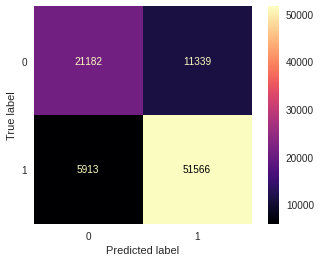

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot(include_values=True, ax=None, cmap='magma')
plt.grid(False)
plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/confusion_matrix.jpg')
plt.show()

In [ ]:
loaded_model_pkl_best.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           27819600  
                                                                 
 lstm_3 (LSTM)               (None, 300)               721200    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 28,541,101
Trainable params: 721,501
Non-trainable params: 27,819,600
_________________________________________________________________


In [ ]:
#classification_report(test_labels[0:90000], pred_int_pkl[0:90000], target_names=target_names))
print(classification_report(test_labels[0:90000], pred_int_pkl[0:90000], target_names=(['Rotten', 'Fresh'])))

              precision    recall  f1-score   support

      Rotten       0.78      0.65      0.71     32521
       Fresh       0.82      0.90      0.86     57479

    accuracy                           0.81     90000
   macro avg       0.80      0.77      0.78     90000
weighted avg       0.81      0.81      0.80     90000



In [ ]:
test_padded[[0]]

array([[ 257, 4775,   24,  154, 1931,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
test_padded[[0]][0]

array([ 257, 4775,   24,  154, 1931,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
pred_padded_0 = model_lstm_10.predict(test_padded[[0]])
pred_int_0 = pred_padded_0.round().astype("int")
print(pred_int_0)
pred_int_0[0][0]

[[0]]


0

In [ ]:
y_test

121868    1
34846     0
294334    1
222376    1
122662    0
         ..
25462     1
268213    0
147680    1
154735    0
147997    1
Name: Type, Length: 90000, dtype: int64

In [ ]:
pred_padded_0 = model_lstm_10.predict(test_padded[0:90000])
pred_int_0 = pred_padded_0.round().astype("int")
print(pred_int_0)

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


In [ ]:
test_labels

121868    1
34846     0
294334    1
222376    1
122662    0
         ..
25462     1
268213    0
147680    1
154735    0
147997    1
Name: Type, Length: 90000, dtype: int64

In [ ]:
pred_padded_pkl = loaded_model_pkl_best.predict(test_padded[0:90000])
pred_int_pkl = pred_padded_pkl.round().astype("int")

In [ ]:
test_padded[0]

array([ 257, 4775,   24,  154, 1931,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
padded[0:5]

array([[   74,  3446,  9805,  6838,   301,  3742,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  162,   157, 15726,  5057,  3351,  3432,   320,   653,    76,
           50,  7509,    40,  2622,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  169,    11,  7095,  7565,   658,  3124,  4766,   175, 27253,
           78,    79,   577,   686,  4994, 30396,  3071,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [ ]:
y_pred = loaded_model_pkl_best.predict(padded[0:5])
y_pred_int = y_pred.round().astype("int")

In [ ]:
reviews_300k.iloc[0:5:,:]

Text  Type
0      real meat potato proposition satisfying tasty     1
1  young old jock nerd geek freak everyone able f...     1
2  strong performance thornton kinnear barely com...     1
3     entertaining romp succeeds level pure escapism     1
4  borgesian critique exotic backdrop scoundrel h...     1

In [ ]:
y_pred

array([[0.99819595],
       [0.9995609 ],
       [0.9983071 ],
       [0.99900824],
       [0.9895733 ]], dtype=float32)

In [ ]:
y_pred_int

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
sequences[4]

[64145, 2582, 2856, 2228, 11011, 143, 1677]

In [ ]:
reviews_300k.iloc[4:]

Text  Type
4       borgesian critique exotic backdrop scoundrel h...     1
5       abel ferrara movie sort damaged raging unrepen...     1
6       acting effect firstrate cast crew make sure fi...     1
7       nightcrawler clever thriller scoop go straight...     1
8       extremely dull every sense even devoted fan fi...     0
...                                                   ...   ...
299995  may way mix monumental tragedy native american...     0
299996               hopkins performance performance film     1
299997  much movie nothing happens rigorous lockedin n...     0
299998  fate cruel trick taking heath ledger u midway ...     1
299999  scene end going nowhere gritty reality sometim...     0

[299996 rows x 2 columns]

In [ ]:
padded[4]

array([64145,  2582,  2856,  2228, 11011,   143,  1677,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
padded[4]

array([64145,  2582,  2856,  2228, 11011,   143,  1677,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [ ]:
padded[4].reshape(1, -1)

array([[64145,  2582,  2856,  2228, 11011,   143,  1677,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
loaded_model_joblib.predict(padded[4].reshape(1, -1))

array([[0.9895733]], dtype=float32)

In [ ]:
test_a = np.matrix([[1, 2, 3, 4], [5, 6, 7, 8]])
test_b = np.reshape(test_a, -1)
test_c = np.reshape(-1, 1)

In [ ]:
test_a

matrix([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [ ]:
print(test_a.shape)
print(test_b.shape)
print(test_c.shape)

(2, 4)
(1, 8)
(1,)


Check inverse

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [ ]:
decode(sequences[4])

'borgesian critique exotic backdrop scoundrel hollywood redemption'

In [ ]:
reviews.head(10)

Text  Type
0  fantasy adventure fuses greek mythology contem...     0
1  uma thurman medusa gorgon coiffure writhing sn...     0
2  topnotch cast dazzling special effects tide te...     0
3  whether audiences get behind lightning thief h...     0
4  whats really lacking lightning thief genuine s...     1
5  list ingredients moviemagic potion enjoy start...     1
6  harry potter knockoffs dont come transparent s...     1
7  percy jackson isnt great movie good one trotti...     0
8                              fun brisk imaginative     0
9  crammed dragons setdestroying fights things ex...     0

In [ ]:
history_pkl = loaded_model_pkl.history

In [ ]:
loaded_model_pkl.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 300)           27819600  
                                                                 
 lstm_13 (LSTM)              (None, 300)               721200    
                                                                 
 dense_13 (Dense)            (None, 1)                 301       
                                                                 
Total params: 28,541,101
Trainable params: 721,501
Non-trainable params: 27,819,600
_________________________________________________________________


In [ ]:
#history = loaded_model_joblib.history

In [ ]:
loaded_model_joblib.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 300)           27819600  
                                                                 
 lstm_13 (LSTM)              (None, 300)               721200    
                                                                 
 dense_13 (Dense)            (None, 1)                 301       
                                                                 
Total params: 28,541,101
Trainable params: 721,501
Non-trainable params: 27,819,600
_________________________________________________________________


In [ ]:
#loaded_model = tensorflow.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/final-project/data/saved_models/model_lstm_1.h5')

### Model Evaluation

In [ ]:
#loaded_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 300)           27819600  
                                                                 
 lstm_13 (LSTM)              (None, 300)               721200    
                                                                 
 dense_13 (Dense)            (None, 1)                 301       
                                                                 
Total params: 28,541,101
Trainable params: 721,501
Non-trainable params: 27,819,600
_________________________________________________________________


#### 1st Iteration (Base)

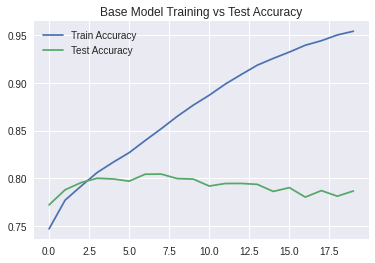

In [ ]:
plt.plot(history_1.history['accuracy'], label='Train Accuracy') 
plt.plot(history_1.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.title('Base Model Training vs Test Accuracy')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/base-model-accuracy.jpg')
plt.show()

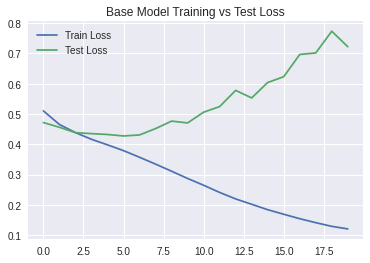

In [ ]:
plt.plot(history_1.history['loss'], label='Train Loss') 
plt.plot(history_1.history['val_loss'], label='Test Loss') 
plt.legend()
plt.title('Base Model Training vs Test Loss')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/base-model-loss.jpg')
plt.show()

#### 2nd Iteration

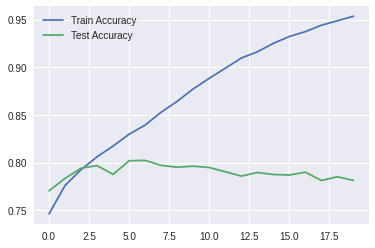

In [ ]:
plt.plot(history_2.history['accuracy'], label='Train Accuracy') 
plt.plot(history_2.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

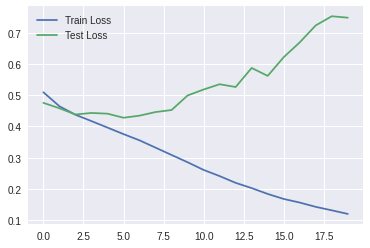

In [ ]:
plt.plot(history_2.history['loss'], label='Train Loss') 
plt.plot(history_2.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 3rd Iteration

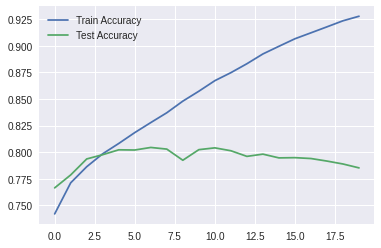

In [ ]:
plt.plot(history_3.history['accuracy'], label='Train Accuracy') 
plt.plot(history_3.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

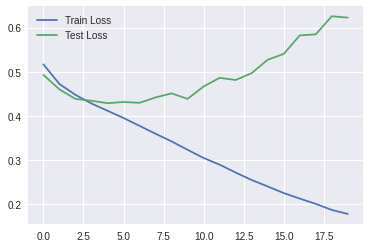

In [ ]:
plt.plot(history_3.history['loss'], label='Train Loss') 
plt.plot(history_3.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 4th Iteration

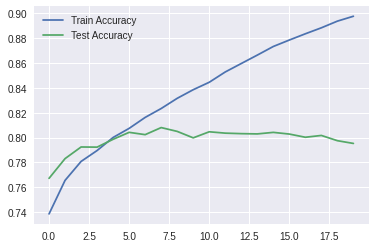

In [ ]:
plt.plot(history_4.history['accuracy'], label='Train Accuracy') 
plt.plot(history_4.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

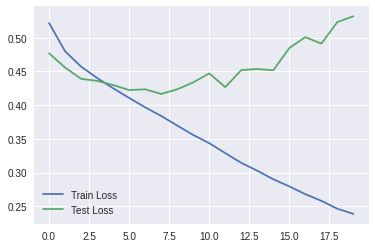

In [ ]:
plt.plot(history_4.history['loss'], label='Train Loss') 
plt.plot(history_4.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 5th Iteration (Best)

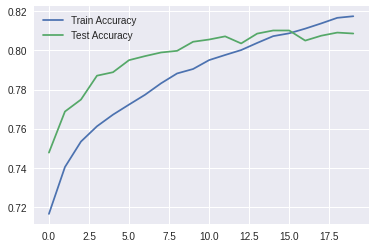

In [ ]:
plt.plot(history_5.history['accuracy'], label='Train Accuracy') 
plt.plot(history_5.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

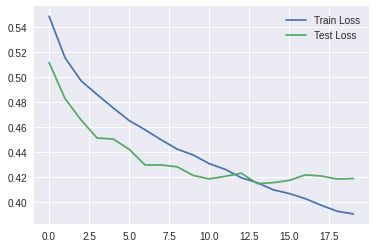

In [ ]:
plt.plot(history_5.history['loss'], label='Train Loss') 
plt.plot(history_5.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

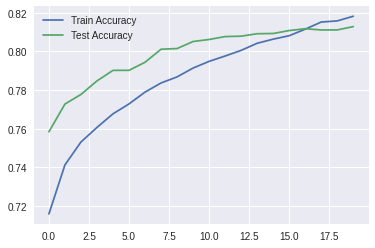

In [ ]:
plt.plot(history_5.history['accuracy'], label='Train Accuracy') 
plt.plot(history_5.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/best-model-accuracy.jpg')
plt.show()

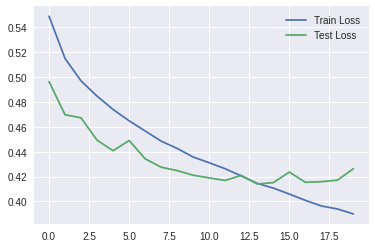

In [ ]:
plt.plot(history_5.history['loss'], label='Train Loss') 
plt.plot(history_5.history['val_loss'], label='Test Loss') 
plt.legend()
plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/best-model-loss.jpg')
plt.show()

#### 6th Iteration

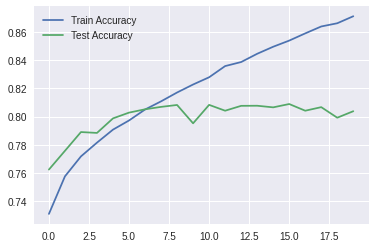

In [ ]:
plt.plot(history_6.history['accuracy'], label='Train Accuracy') 
plt.plot(history_6.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

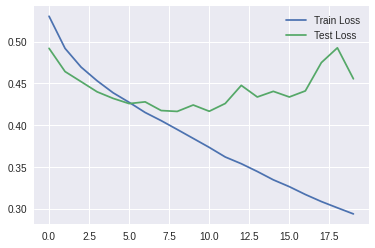

In [ ]:
plt.plot(history_6.history['loss'], label='Train Loss') 
plt.plot(history_6.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 7th Iteration

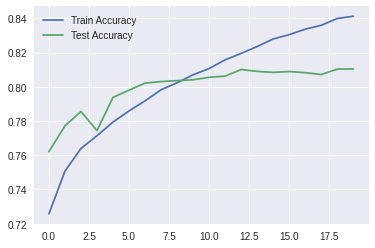

In [ ]:
plt.plot(history_7.history['accuracy'], label='Train Accuracy') 
plt.plot(history_7.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

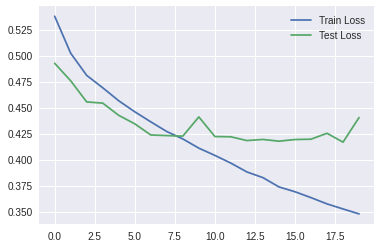

In [ ]:
plt.plot(history_7.history['loss'], label='Train Loss') 
plt.plot(history_7.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 8th Iteration

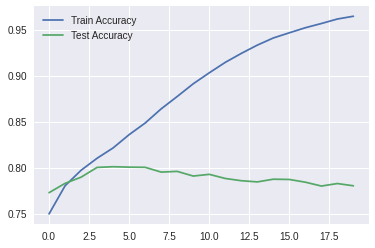

In [ ]:
plt.plot(history_8.history['accuracy'], label='Train Accuracy') 
plt.plot(history_8.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

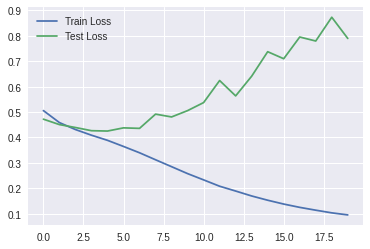

In [ ]:
plt.plot(history_8.history['loss'], label='Train Loss') 
plt.plot(history_8.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 9th Iteration

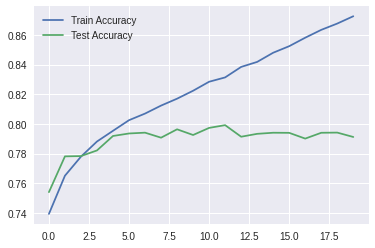

In [ ]:
plt.plot(history_9.history['accuracy'], label='Train Accuracy') 
plt.plot(history_9.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

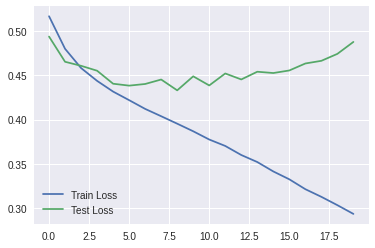

In [ ]:
plt.plot(history_9.history['loss'], label='Train Loss') 
plt.plot(history_9.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 10th Iteration

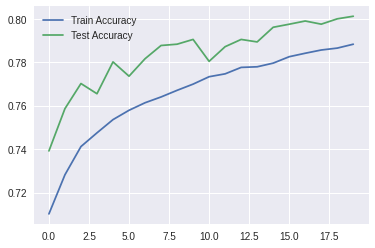

In [ ]:
plt.plot(history_10.history['accuracy'], label='Train Accuracy') 
plt.plot(history_10.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

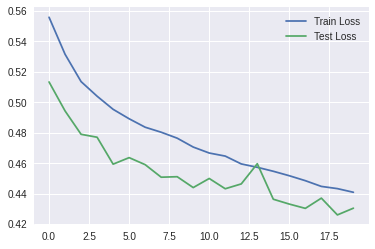

In [ ]:
plt.plot(history_10.history['loss'], label='Train Loss') 
plt.plot(history_10.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

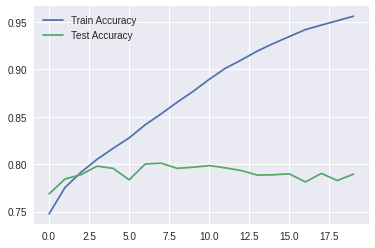

In [ ]:
plt.plot(history_11.history['accuracy'], label='Train Accuracy') 
plt.plot(history_11.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

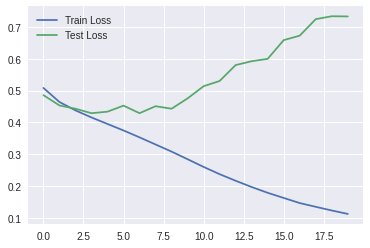

In [ ]:
plt.plot(history_11.history['loss'], label='Train Loss') 
plt.plot(history_11.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

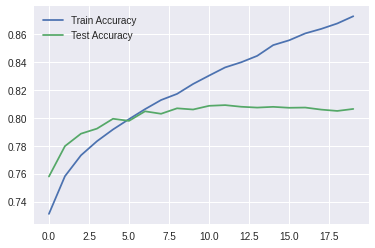

In [ ]:
plt.plot(history_12.history['accuracy'], label='Train Accuracy') 
plt.plot(history_12.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

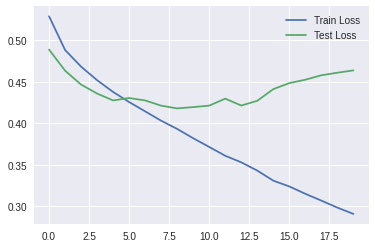

In [ ]:
plt.plot(history_12.history['loss'], label='Train Loss') 
plt.plot(history_12.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

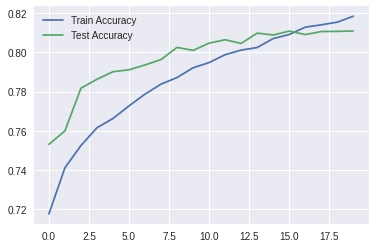

In [ ]:
plt.plot(history_13.history['accuracy'], label='Train Accuracy') 
plt.plot(history_13.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

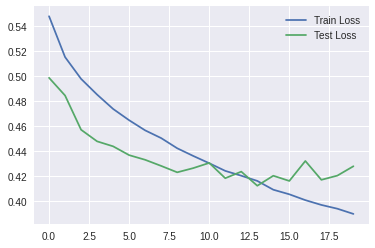

In [ ]:
plt.plot(history_13.history['loss'], label='Train Loss') 
plt.plot(history_13.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

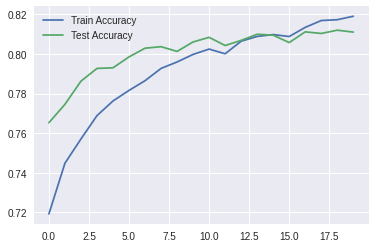

In [ ]:
plt.plot(history_14.history['accuracy'], label='Train Accuracy') 
plt.plot(history_14.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

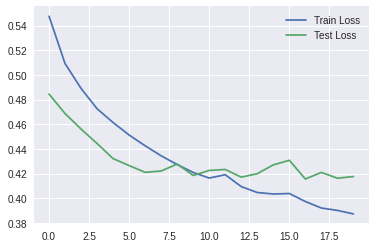

In [ ]:
plt.plot(history_14.history['loss'], label='Train Loss') 
plt.plot(history_14.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 15th Iteration

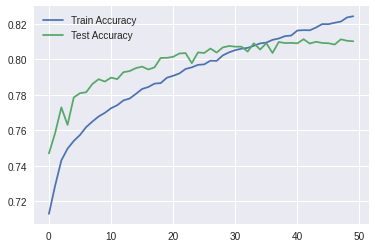

In [ ]:
plt.plot(history_15.history['accuracy'], label='Train Accuracy') 
plt.plot(history_15.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

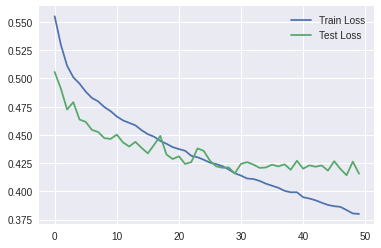

In [ ]:
plt.plot(history_15.history['loss'], label='Train Loss') 
plt.plot(history_15.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

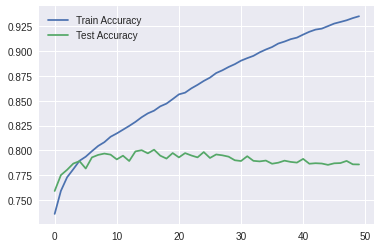

In [ ]:
plt.plot(history_16.history['accuracy'], label='Train Accuracy') 
plt.plot(history_16.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

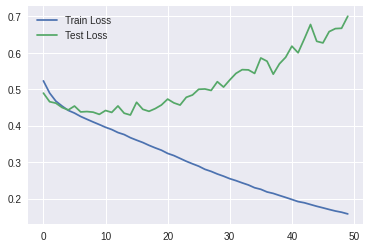

In [ ]:
plt.plot(history_16.history['loss'], label='Train Loss') 
plt.plot(history_16.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

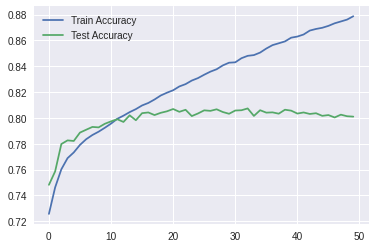

In [ ]:
plt.plot(history_17.history['accuracy'], label='Train Accuracy') 
plt.plot(history_17.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

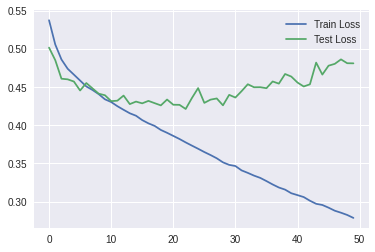

In [ ]:
plt.plot(history_17.history['loss'], label='Train Loss') 
plt.plot(history_17.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

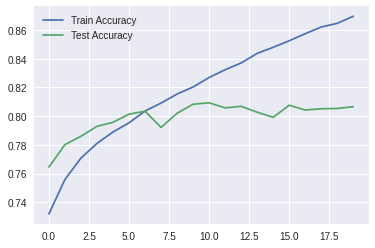

In [ ]:
plt.plot(history_18.history['accuracy'], label='Train Accuracy') 
plt.plot(history_18.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

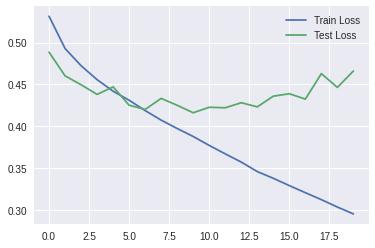

In [ ]:
plt.plot(history_18.history['loss'], label='Train Loss') 
plt.plot(history_18.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 19th Iteration

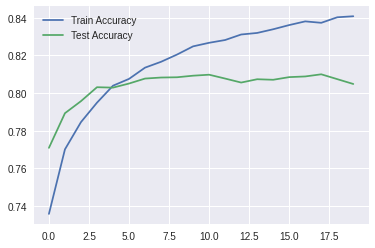

In [ ]:
plt.plot(history_19.history['accuracy'], label='Train Accuracy') 
plt.plot(history_19.history['val_accuracy'], label='Test Accuracy') 
plt.legend() 
plt.show()

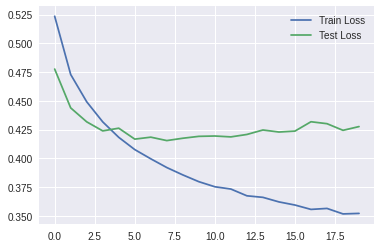

In [ ]:
plt.plot(history_19.history['loss'], label='Train Loss') 
plt.plot(history_19.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 20th Iteration

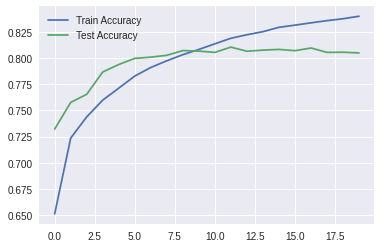

In [ ]:
plt.plot(history_20.history['accuracy'], label='Train Accuracy') 
plt.plot(history_20.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

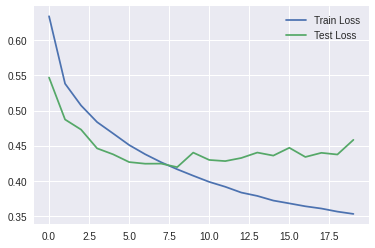

In [ ]:
plt.plot(history_20.history['loss'], label='Train Loss') 
plt.plot(history_20.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 21st Iteration

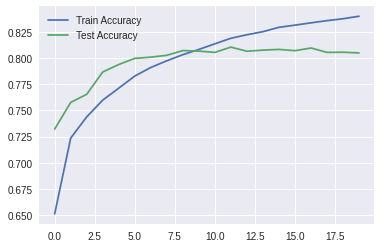

In [ ]:
plt.plot(history_21.history['accuracy'], label='Train Accuracy') 
plt.plot(history_21.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

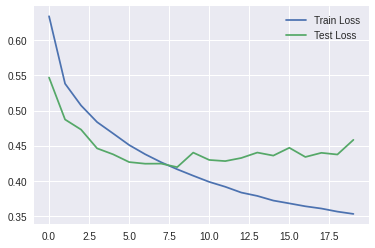

In [ ]:
plt.plot(history_21.history['loss'], label='Train Loss') 
plt.plot(history_21.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 22nd Iteration

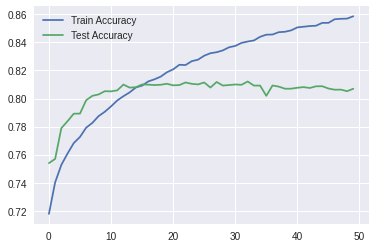

In [ ]:
plt.plot(history_22.history['accuracy'], label='Train Accuracy') 
plt.plot(history_22.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

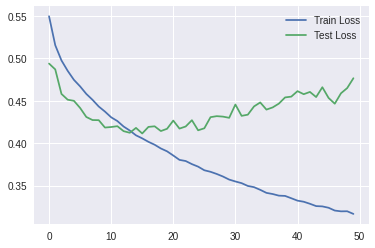

In [ ]:
plt.plot(history_22.history['loss'], label='Train Loss') 
plt.plot(history_22.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 23rd Iteration

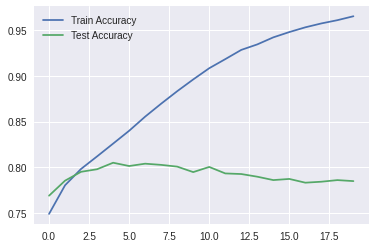

In [ ]:
plt.plot(history_23.history['accuracy'], label='Train Accuracy') 
plt.plot(history_23.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

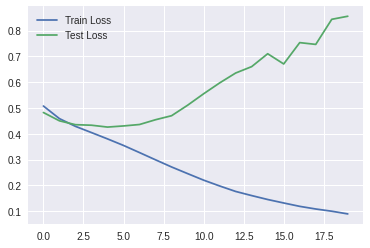

In [ ]:
plt.plot(history_23.history['loss'], label='Train Loss') 
plt.plot(history_23.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 24th Iteration

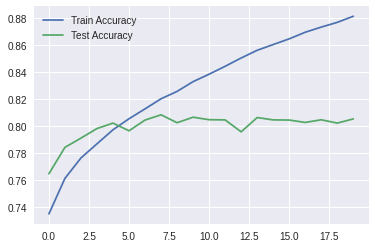

In [ ]:
plt.plot(history_24.history['accuracy'], label='Train Accuracy') 
plt.plot(history_24.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

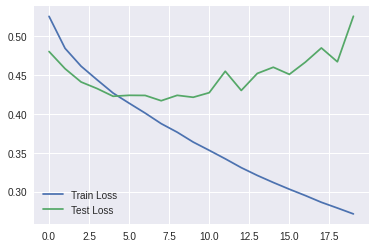

In [ ]:
plt.plot(history_24.history['loss'], label='Train Loss') 
plt.plot(history_24.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 25th Iteration

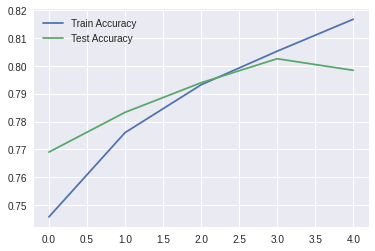

In [ ]:
plt.plot(history_25.history['accuracy'], label='Train Accuracy') 
plt.plot(history_25.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

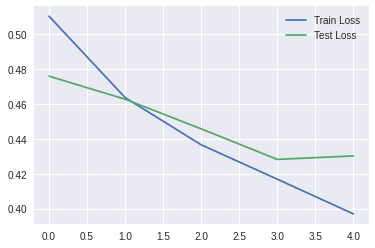

In [ ]:
plt.plot(history_25.history['loss'], label='Train Loss') 
plt.plot(history_25.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### 26th Iteration

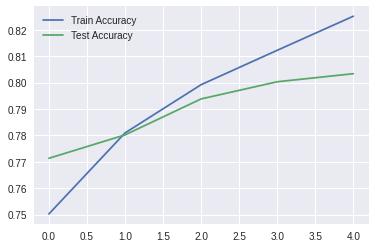

In [ ]:
plt.plot(history_26.history['accuracy'], label='Train Accuracy') 
plt.plot(history_26.history['val_accuracy'], label='Test Accuracy') 
plt.legend()
plt.show()

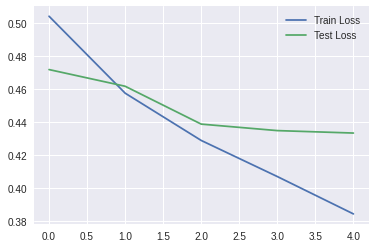

In [ ]:
plt.plot(history_26.history['loss'], label='Train Loss') 
plt.plot(history_26.history['val_loss'], label='Test Loss') 
plt.legend()
plt.show()

#### Base vs Best Model

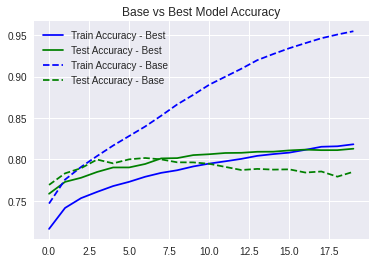

In [ ]:
#plt.figure(figsize=(10,6))
# Plot best model accuracy
plt.plot(history_5.history['accuracy'], label='Train Accuracy - Best', color='blue')
plt.plot(history_5.history['val_accuracy'], label='Test Accuracy - Best', color='green')
# Plot base model accuracy
plt.plot(history_1.history['accuracy'], label='Train Accuracy - Base', color='blue', linestyle='dashed')
plt.plot(history_1.history['val_accuracy'], label='Test Accuracy - Base', color='green', linestyle='dashed')

plt.legend()
plt.title('Base vs Best Model Accuracy')
plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/base-vs-best-model-accuracy.jpg')
plt.show()

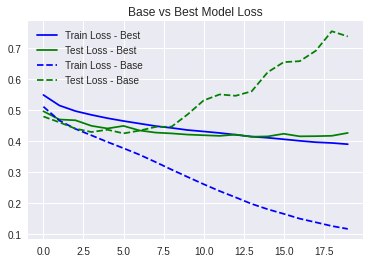

In [ ]:
#plt.figure(figsize=(10,6))
# Plot best model loss
plt.plot(history_5.history['loss'], label='Train Loss - Best', color='blue') 
plt.plot(history_5.history['val_loss'], label='Test Loss - Best', color='green')
# Plot base model loss
plt.plot(history_1.history['loss'], label='Train Loss - Base', color='blue', linestyle='dashed') 
plt.plot(history_1.history['val_loss'], label='Test Loss - Base', color='green', linestyle='dashed') 

plt.legend()
plt.title('Base vs Best Model Loss')
plt.savefig('/content/drive/My Drive/Colab Notebooks/final-project/output/img/base-vs-best-model-loss.jpg')
plt.show()

In [ ]:
# Save the trained model as a pickle string.
#saved_model = pickle.dumps(history)